# MUSIC RECOMMENDATION

# By Srilatha

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import missingno as msno
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,mean_squared_error,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,VotingClassifier,AdaBoostClassifier
import lightgbm as lgb
import datetime
import math

In [2]:
import lightgbm as lgb
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report,roc_curve
from tqdm import tqdm

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = reduce_mem_usage(pd.read_csv('train.csv'))
test = reduce_mem_usage(pd.read_csv('test.csv'))
sei = pd.read_csv('song_extra_info.csv')
members = pd.read_csv('members.csv',parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv('songs.csv')

Memory usage of dataframe is 337.71 MB
Memory usage after optimization is: 82.41 MB
Decreased by 75.6%
Memory usage of dataframe is 117.04 MB
Memory usage after optimization is: 42.17 MB
Decreased by 64.0%


In [5]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [6]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [7]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [8]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [9]:
members.shape
train.info()
print("\n")
songs.info()
print("\n")
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              int8    
dtypes: category(5), int8(1)
memory usage: 82.4 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count

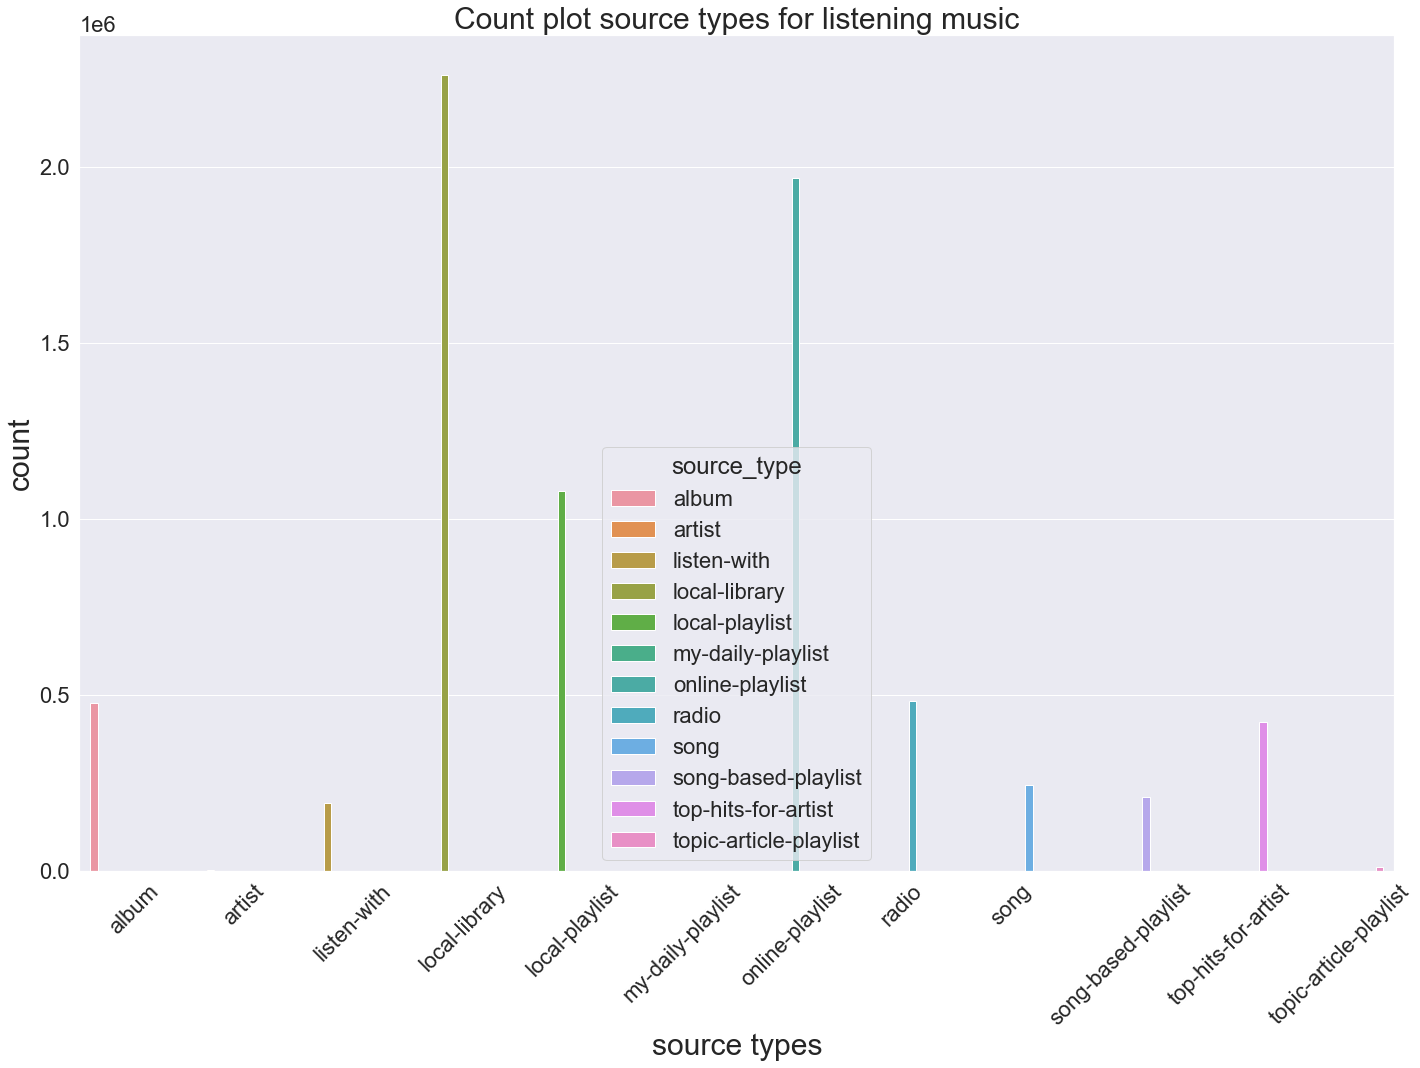

In [10]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_type',hue='source_type',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot source types for listening music',fontsize=30)
plt.tight_layout()

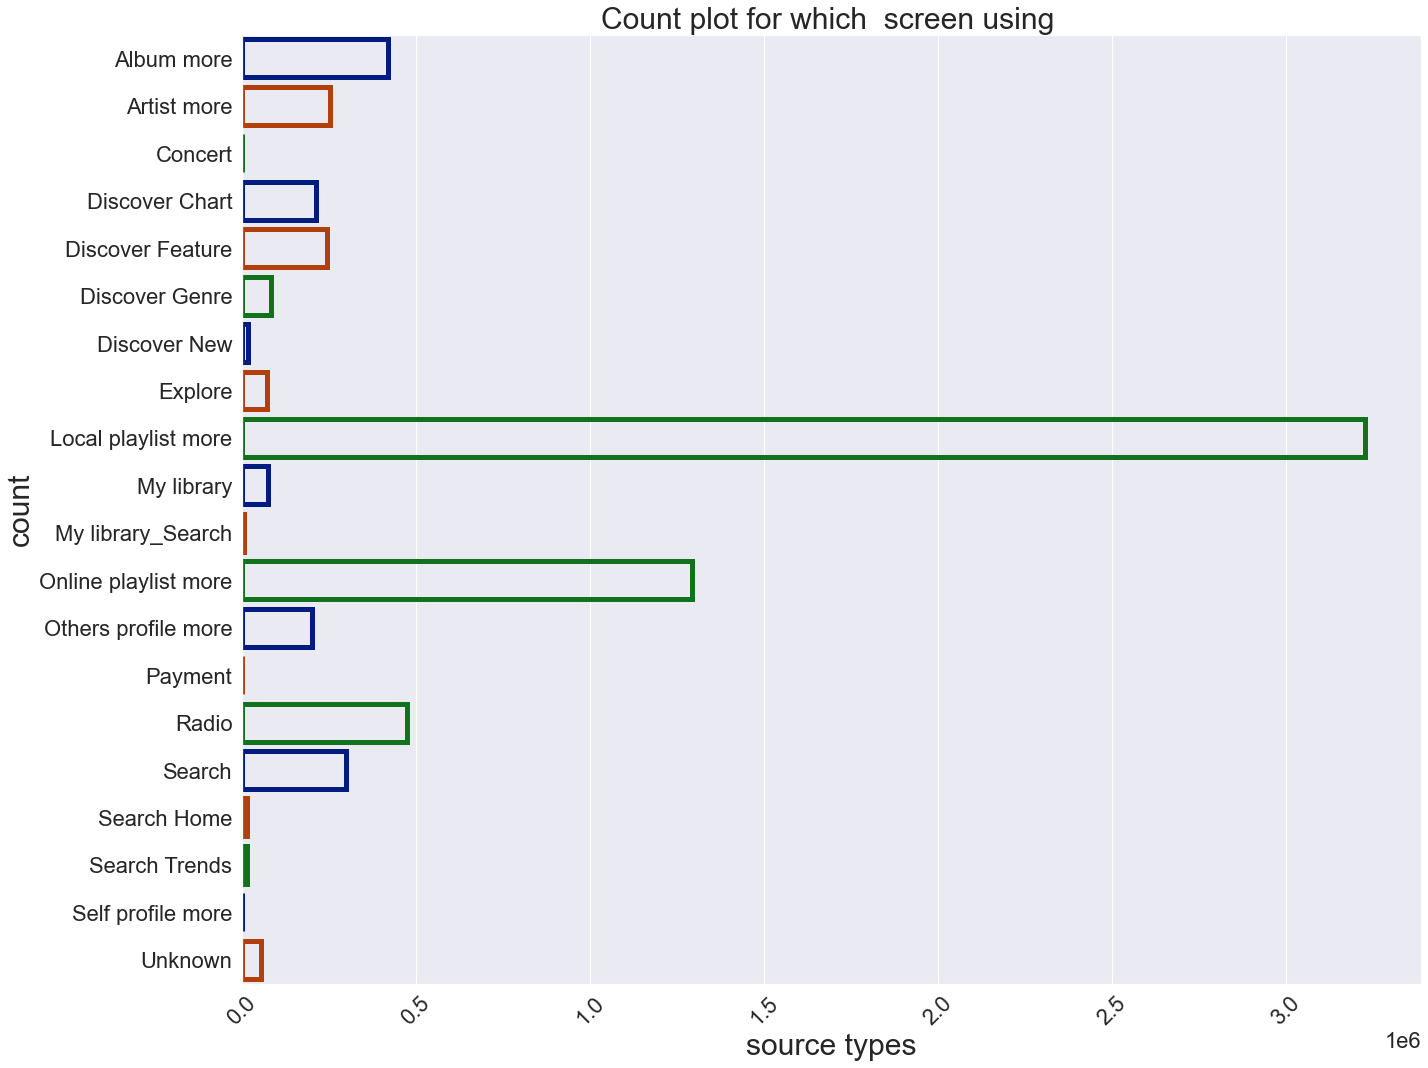

In [11]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(y='source_screen_name',data=train,facecolor=(0,0,0,0),linewidth=5,edgecolor=sns.color_palette('dark',3))
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for which  screen using ',fontsize=30)
plt.tight_layout()

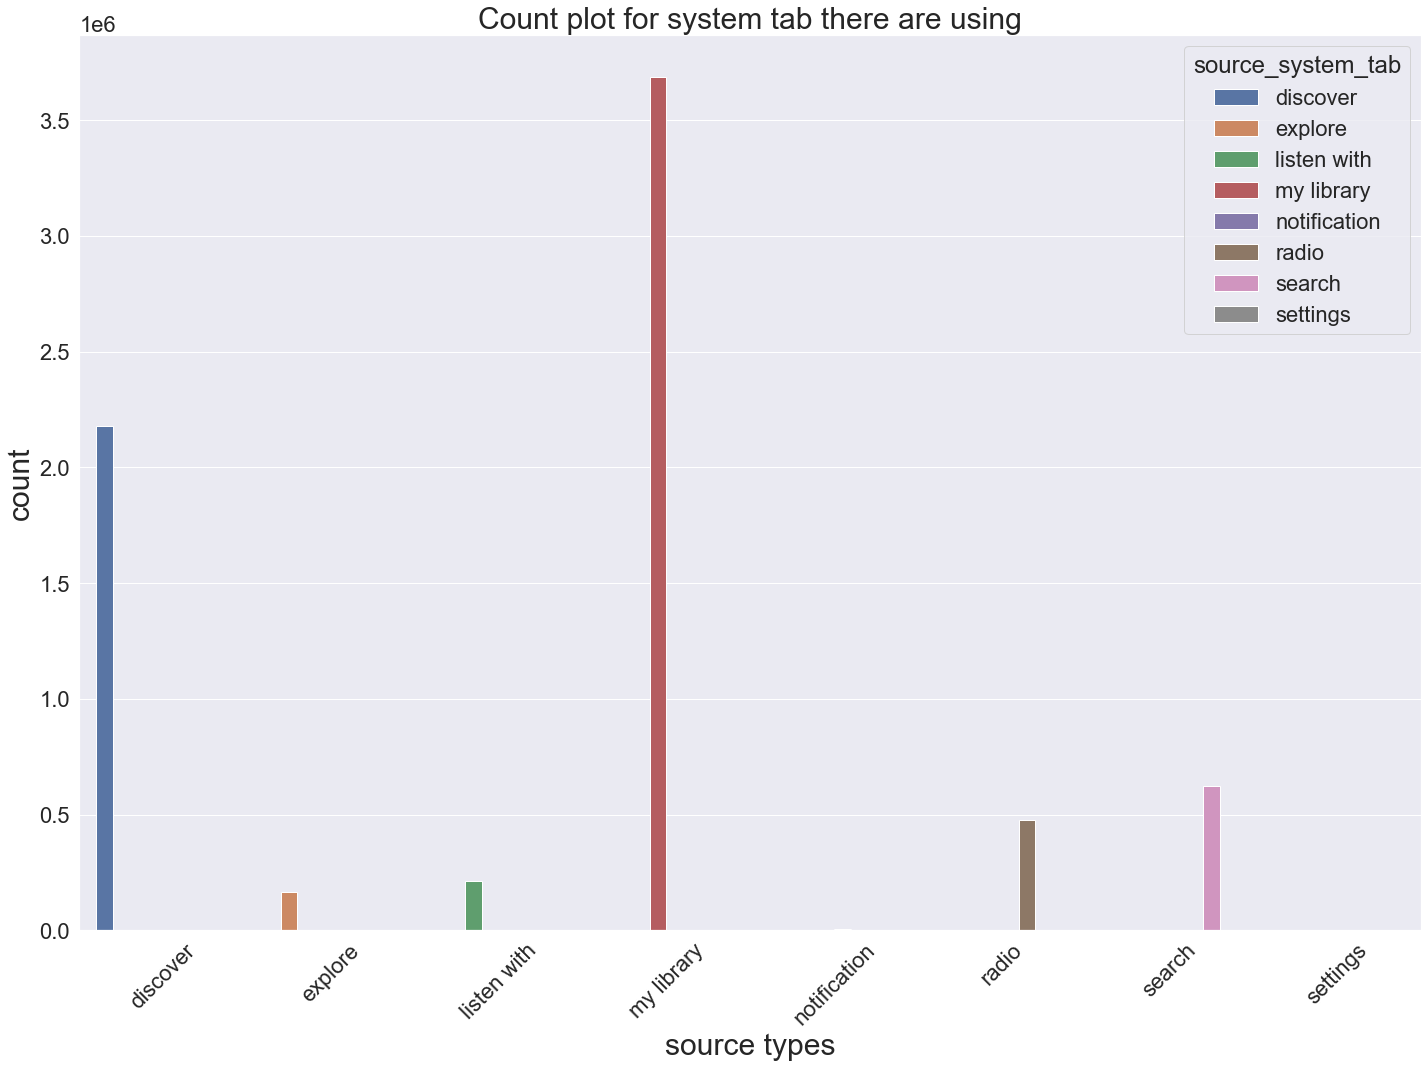

In [12]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)
sns.set(style="darkgrid")
plt.xlabel('source types',fontsize=30)
plt.ylabel('count',fontsize=30)
plt.xticks(rotation='45')
plt.title('Count plot for system tab there are using',fontsize=30)
plt.tight_layout()


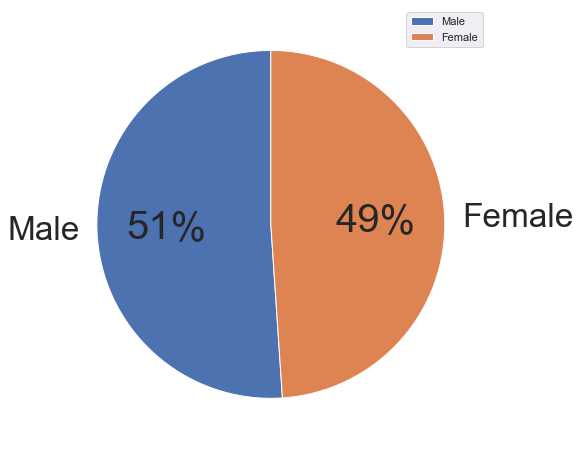

In [13]:
import matplotlib as mpl

mpl.rcParams['font.size'] = 40.0
labels = ['Male','Female']
plt.figure(figsize = (8, 8))
sizes = pd.value_counts(members.gender)
patches, texts, autotexts = plt.pie(sizes, 
                                    labels=labels, autopct='%.0f%%',
                                    shadow=False, radius=1,startangle=90)
for t in texts:
    t.set_size('smaller')
plt.legend()
plt.show()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: source_system_tab, dtype: int64


<Figure size 1440x1440 with 0 Axes>

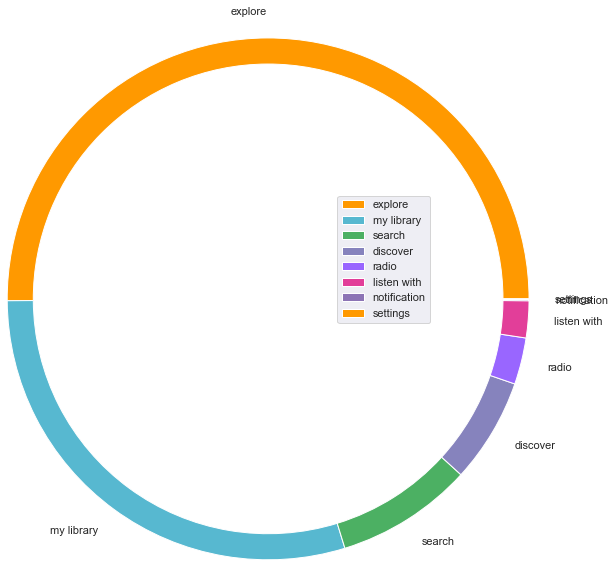

In [14]:
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
# Make data: I have 3 groups and 7 subgroups
group_names=['explore','my library','search','discover','radio','listen with','notification','settings']
group_size=pd.value_counts(train.source_system_tab)
print(group_size)
subgroup_names=['Male','Female']
subgroup_size=pd.value_counts(members.gender)
 
# Create colors
a, b, c,d,e,f,g,h=[plt.cm.autumn, plt.cm.GnBu, plt.cm.YlGn,plt.cm.Purples,plt.cm.cool,plt.cm.RdPu,plt.cm.BuPu,plt.cm.bone]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, texts= ax.pie(group_size, radius=3.0,labels=group_names, colors=[a(0.6), b(0.6), c(0.6),d(0.6), e(0.6), f(0.6),g(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
#mypie2, texts1 = ax.pie(subgroup_size, radius=3.0-0.3, labels=subgroup_names, labeldistance=0.7, colors=[h(0.5), b(0.4)])
#plt.setp( mypie2, width=0.3, edgecolor='white')
#plt.margins(0,0)
#for t in texts:
 #   t.set_size(25.0)
#for t in texts1:
 
    #t.set_size(25.0)    
plt.legend() 
# show it
plt.show()

In [15]:
print(members.describe())

               city            bd  registered_via
count  34403.000000  34403.000000    34403.000000
mean       5.371276     12.280935        5.953376
std        6.243929     18.170251        2.287534
min        1.000000    -43.000000        3.000000
25%        1.000000      0.000000        4.000000
50%        1.000000      0.000000        7.000000
75%       10.000000     25.000000        9.000000
max       22.000000   1051.000000       16.000000


In [16]:
print(songs.describe())

        song_length      language
count  2.296320e+06  2.296319e+06
mean   2.469935e+05  3.237800e+01
std    1.609200e+05  2.433241e+01
min    1.850000e+02 -1.000000e+00
25%    1.836000e+05 -1.000000e+00
50%    2.266270e+05  5.200000e+01
75%    2.772690e+05  5.200000e+01
max    1.217385e+07  5.900000e+01


In [17]:
members.describe()

,city,bd,registered_via
count,34403.000000,34403.000000,34403.000000
mean,5.371276,12.280935,5.953376
std,6.243929,18.170251,2.287534
min,1.000000,-43.000000,3.000000
25%,1.000000,0.000000,4.000000
50%,1.000000,0.000000,7.000000
75%,10.000000,25.000000,9.000000
max,22.000000,1051.000000,16.000000


In [18]:
songs.describe()

,song_length,language
count,2.296320e+06,2.296319e+06
mean,2.469935e+05,3.237800e+01
std,1.609200e+05,2.433241e+01
min,1.850000e+02,-1.000000e+00
25%,1.836000e+05,-1.000000e+00
50%,2.266270e+05,5.200000e+01
75%,2.772690e+05,5.200000e+01
max,1.217385e+07,5.900000e+01


In [19]:
train.describe()

,target
count,7.377418e+06
mean,5.035171e-01
std,4.999877e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              int8    
dtypes: category(5), int8(1)
memory usage: 82.4 MB


In [21]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   msno                    34403 non-null  object        
 1   city                    34403 non-null  int64         
 2   bd                      34403 non-null  int64         
 3   gender                  14501 non-null  object        
 4   registered_via          34403 non-null  int64         
 5   registration_init_time  34403 non-null  datetime64[ns]
 6   expiration_date         34403 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 1.8+ MB


In [22]:
train_members = pd.merge(train, members, on='msno', how='inner')
train_merged = pd.merge(train_members, songs, on='song_id', how='outer')
print(train_merged.head())

                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=   
2  xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=   
3  s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=   
4  Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=          discover   
2  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
3  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   
4  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=        my library   

     source_screen_name      source_type  target  city    bd  gender  \
0               Explore  online-playlist     1.0   1.0   0.0     NaN   
1  Online playlist more  online-playlist     0.0  15.0  18.0    male   
2   Local playlist more    local-library     1.0   1.0   0.0  

In [23]:
test_members = pd.merge(test, members, on='msno', how='inner')
test_merged = pd.merge(test_members, songs, on='song_id', how='outer')
print(test_merged.head())
print(len(test_merged.columns))

          id                                          msno  \
0        0.0  V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=   
1  1035059.0  08rvvaaab7dM7h78GC4SphLkUCSXPxpu6sY+k8aLUO4=   
2    89968.0  1NvrMNDUcvfqOIjhim8BgdK23znMzGwAO84W+qKs6dw=   
3   972394.0  GfSXhTVP3oj7h0545L/5xh6jD+7edQ7AH0iprl7dYbc=   
4  2194574.0  HkWEvfQyrb5Lve8X3B7HkCEkDFW8qFy/9kWFb4QbM5k=   

                                        song_id source_system_tab  \
0  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
1  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
2  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
3  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=        my library   
4  WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=          discover   

    source_screen_name          source_type  city    bd  gender  \
0  Local playlist more        local-library   1.0   0.0     NaN   
1  Local playlist more        local-library   5.0  29.0  female   
2  Local pl

In [24]:
del train_members
del test_members

In [25]:
#--- Function to check if missing values are present and if so print the columns having them ---
def check_missing_values(df):
    print (df.isnull().values.any())
    if (df.isnull().values.any() == True):
        columns_with_Nan = df.columns[df.isnull().any()].tolist()
    print(columns_with_Nan)
    for col in columns_with_Nan:
        print("%s : %d" % (col, df[col].isnull().sum()))
    
check_missing_values(train_merged)
check_missing_values(test_merged)

True
['msno', 'source_system_tab', 'source_screen_name', 'source_type', 'target', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
msno : 1936406
source_system_tab : 1961255
source_screen_name : 2351210
source_type : 1957945
target : 1936406
city : 1936406
bd : 1936406
gender : 4897885
registered_via : 1936406
registration_init_time : 1936406
expiration_date : 1936406
song_length : 114
genre_ids : 205338
artist_name : 114
composer : 2591558
lyricist : 4855358
language : 150
True
['id', 'msno', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
id : 2071581
msno : 2071581
source_system_tab : 2080023
source_screen_name : 2234464
source_type : 2078878
city : 2071581
bd : 2071581
gender : 3123805
register

In [26]:
#--- Function to replace Nan values in columns of type float with -5 ---
def replace_Nan_non_object(df):
    object_cols = list(df.select_dtypes(include=['float']).columns)
    for col in object_cols:
        df[col]=df[col].fillna(np.int(-5))
       
replace_Nan_non_object(train_merged) 
replace_Nan_non_object(test_merged)

In [27]:
#--- memory consumed by train dataframe ---
mem = train_merged.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
 
#--- memory consumed by test dataframe ---
mem = test_merged.memory_usage(index=True).sum()
print("Memory consumed by test set      :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   1163.5898780822754 MB
Memory consumed by test set      :   578.2299928665161 MB


In [28]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)

change_datatype(train_merged)
change_datatype(test_merged)

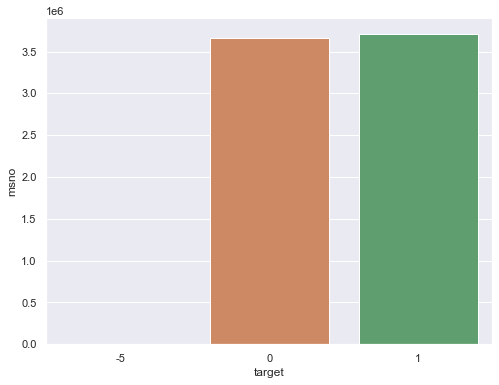

In [29]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='target', y='msno', data=data)

<AxesSubplot:xlabel='source_system_tab', ylabel='msno'>

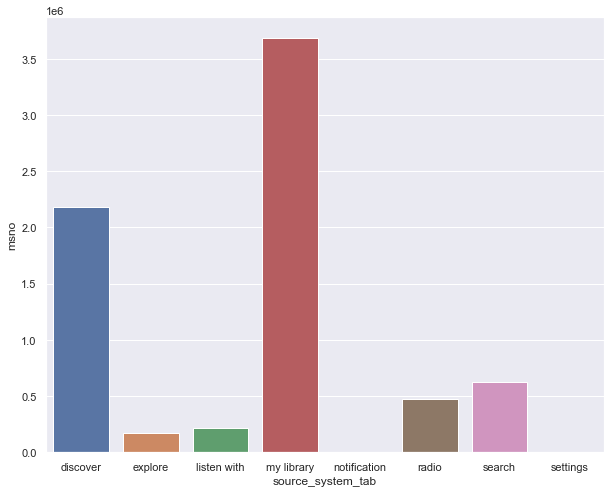

In [30]:
mpl.rcParams['font.size'] = 40.0
plt.figure(figsize = (10, 8)) 
data=train_merged.groupby('source_system_tab').aggregate({'msno':'count'}).reset_index()
sns.barplot(x='source_system_tab',y='msno',data=data)

[Text(0, 0, 'Album more'),
 Text(1, 0, 'Artist more'),
 Text(2, 0, 'Concert'),
 Text(3, 0, 'Discover Chart'),
 Text(4, 0, 'Discover Feature'),
 Text(5, 0, 'Discover Genre'),
 Text(6, 0, 'Discover New'),
 Text(7, 0, 'Explore'),
 Text(8, 0, 'Local playlist more'),
 Text(9, 0, 'My library'),
 Text(10, 0, 'My library_Search'),
 Text(11, 0, 'Online playlist more'),
 Text(12, 0, 'Others profile more'),
 Text(13, 0, 'Payment'),
 Text(14, 0, 'Radio'),
 Text(15, 0, 'Search'),
 Text(16, 0, 'Search Home'),
 Text(17, 0, 'Search Trends'),
 Text(18, 0, 'Self profile more'),
 Text(19, 0, 'Unknown')]

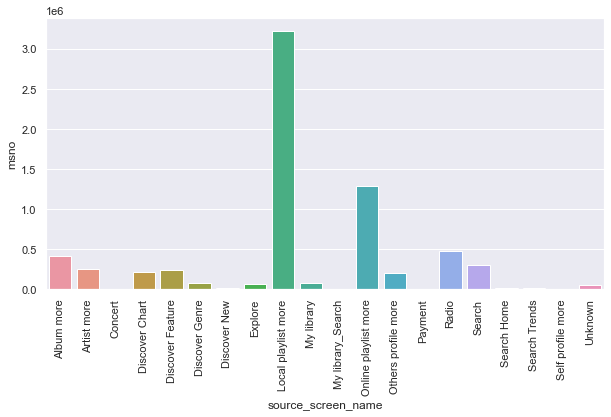

In [31]:
data = train_merged.groupby('source_screen_name').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_screen_name', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'album'),
 Text(1, 0, 'artist'),
 Text(2, 0, 'listen-with'),
 Text(3, 0, 'local-library'),
 Text(4, 0, 'local-playlist'),
 Text(5, 0, 'my-daily-playlist'),
 Text(6, 0, 'online-playlist'),
 Text(7, 0, 'radio'),
 Text(8, 0, 'song'),
 Text(9, 0, 'song-based-playlist'),
 Text(10, 0, 'top-hits-for-artist'),
 Text(11, 0, 'topic-article-playlist')]

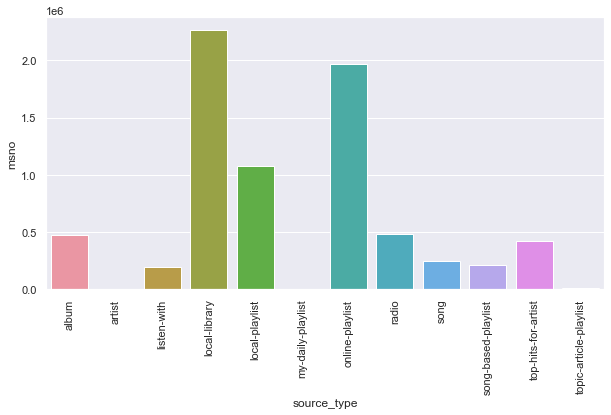

In [32]:
data = train_merged.groupby('source_type').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='source_type', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(1, 0, '-1'),
 Text(2, 0, '3'),
 Text(3, 0, '10'),
 Text(4, 0, '17'),
 Text(5, 0, '24'),
 Text(6, 0, '31'),
 Text(7, 0, '38'),
 Text(8, 0, '45'),
 Text(9, 0, '52'),
 Text(10, 0, '59')]

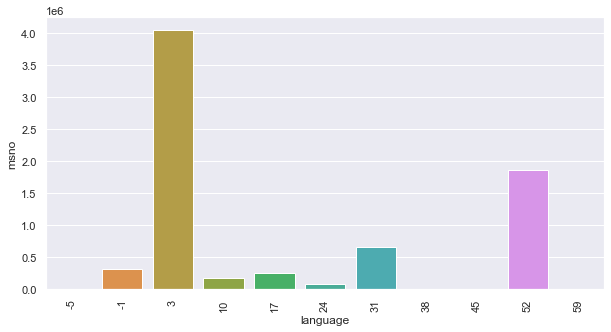

In [33]:
data = train_merged.groupby('language').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='language', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '-5'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '7'),
 Text(4, 0, '9'),
 Text(5, 0, '13')]

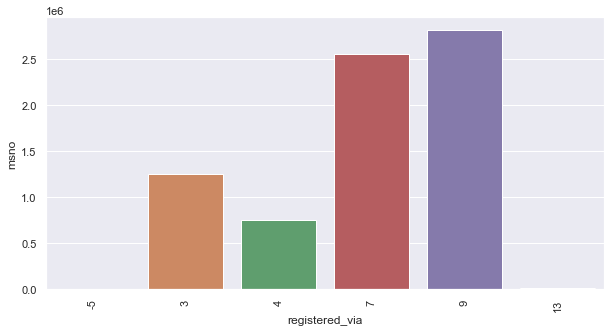

In [34]:
data = train_merged.groupby('registered_via').aggregate({'msno':'count'}).reset_index()
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='registered_via', y='msno', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

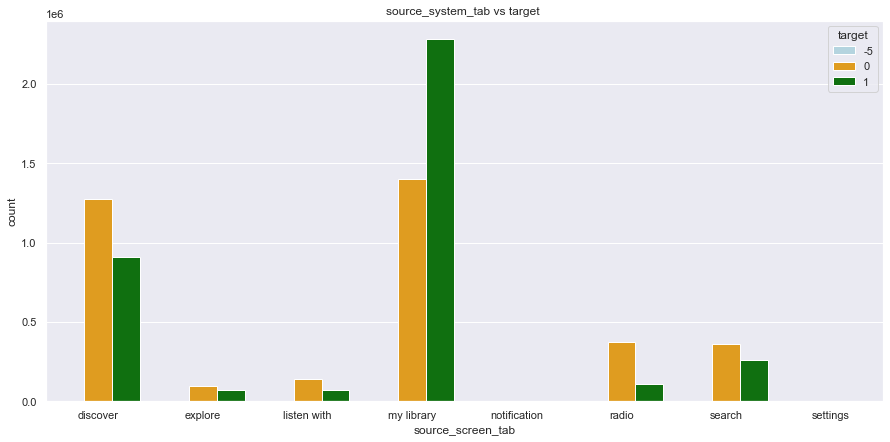

In [35]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_system_tab",data=train_merged,palette=['lightblue','orange','green'],hue="target")
plt.xlabel("source_screen_tab")
plt.ylabel("count")
plt.title("source_system_tab vs target ")
plt.show()

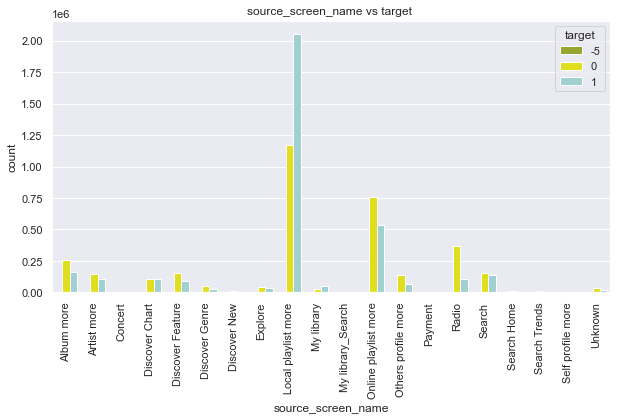

In [36]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="source_screen_name",data=train_merged,palette=['#A8B820','yellow','#98D8D8'],hue="target")
plt.xlabel("source_screen_name")
plt.ylabel("count")
plt.title("source_screen_name vs target ")
plt.xticks(rotation='90')
plt.show()


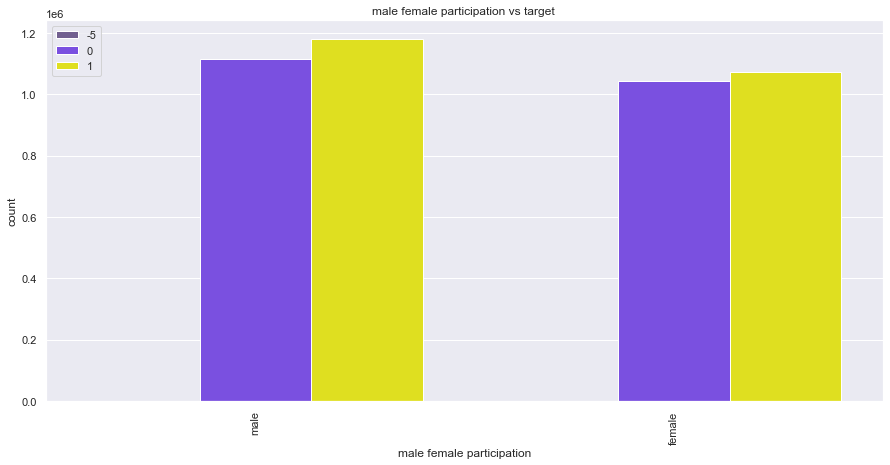

In [37]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.countplot(x="gender",data=train_merged,palette=['#705898','#7038F8','yellow'],hue="target")
plt.xlabel("male female participation")
plt.ylabel("count")
plt.title("male female participation vs target ")
plt.xticks(rotation='90')
plt.legend(loc='upper left')
plt.show()

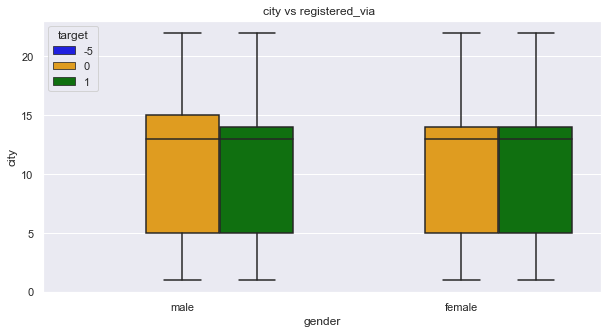

In [38]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=a4_dims)
ax=sns.boxplot(x="gender",y="city",data=train_merged,palette=['blue','orange','green'],hue="target")
plt.xlabel("gender")
plt.ylabel("city")
plt.title("city vs registered_via  ")
plt.show()

In [39]:
print('Shape of train is :',train.shape)
print('Shape of test is :',test.shape)
print('Shape of Song Extra Info is :',sei.shape)
print('Shape of Members is :',members.shape)
print('Shape of Songs is :',songs.shape)

Shape of train is : (7377418, 6)
Shape of test is : (2556790, 6)
Shape of Song Extra Info is : (2295971, 3)
Shape of Members is : (34403, 7)
Shape of Songs is : (2296320, 7)


In [40]:
def get_codes(isrc):
    if pd.isnull(isrc):
        return np.nan
    else:
        if int(str(isrc)[5:7]) > 17:
            temp =  1900+int(str(isrc)[5:7])
        else:
            temp = 2000+int(isrc[5:7])
        return temp

In [41]:
sei['year'] = sei['isrc'].apply(lambda x: get_codes(x))
sei.sample(10)

,song_id,name,isrc,year
1976538,BeTQL5Y4CmLLkTkMJHzzoT0QXk2vHkxyM3APjscfUzY=,Coop,USA561239543,2012.0
883831,egum7Zm46UAamP0wOHNny6upNniPVRHT/XzKNoTJFMk=,Kasmaran,FR2X41636766,2016.0
404868,uzCmu/1Nv8/+CAtLiTMXhJzZcl/WRKqCEUWJs9cM2W4=,Run and Gun (feat. LEON & DOLLARBILL),JPJ901502890,2015.0
627733,8vEeFc2xp0IywnjXHlnyw0ZC/5TS1GryibTe3FAama0=,Jealous,CAK471603602,2016.0
372799,Yq9ipBBrTzELOl4EH/r9SJ2NOPYcQBMUkJHU+gnuoJ0=,糖果,TWA479706003,1997.0
1091522,Yjz/rftBkWtxH3rjmtgSnxpEiYCc3dKAeIwuePJSSEc=,See The Light (Frank Rogers Real Vox Mix),DEM090800301,2008.0
1677069,VBXthBZT9mTEUJzPA3V3qeApsGNo4zBexsJAskZwYPY=,Remember The Rain,NLB150100731,2001.0
2209956,R8CUuKIhzm1b61uRsIiJ5JD8OOxfQnSZ1q920O2WdS4=,University Travel,ITM140900030,2009.0
1818210,Duy03OrCZgPOn5FdTKTpdQ8DDAjd/yAD+KgBhdF1aFg=,I Will Be Blessed,GBARL0000198,2000.0
1466532,fiaJmaDv2XNSw6gL5Y0feuaa/jy9JXn0/VYLDeBq1rE=,Weird,NLG620400928,2004.0


In [42]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)
members['registration_year'] = members['registration_init_time'].dt.year
members['expiration_year'] = members['expiration_date'].dt.year
members.drop(columns = ['registration_init_time' , 'expiration_date'] , inplace = True)
members.head()

,msno,city,bd,gender,registered_via,membership_days,registration_year,expiration_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457,2016,2017
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1,2015,2015
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138,2017,2017


In [43]:
# Extending columns
# merging the database
train = train.merge(songs , on='song_id' , how='left')
train = train.merge(members , on = 'msno' , how='left')
train = train.merge(sei , on = 'song_id' , how='left')
test  = test.merge(songs , on='song_id' , how='left')
test = test.merge(members , on = 'msno' , how = 'left')
test =  test.merge(sei , on = 'song_id' , how = 'left')
del sei ,members , songs
gc.collect()

2957

In [44]:
print(train['song_length'].isnull().value_counts()/train.shape[0])
train['song_length'].fillna(train['song_length'].mean() , inplace = True)
train['song_length'] = train['song_length'].astype(np.uint32)
print(train['language'].isnull().value_counts()/train.shape[0])
train['language'].fillna(train['language'].mode().values[0] , inplace= True)
train['language'] = train['language'].astype(np.int8)
test['song_length'].fillna(test['song_length'].mean() , inplace = True)
test['song_length'] = test['song_length'].astype(np.uint32)
test['language'].fillna(test['language'].mode().values[0] , inplace= True)
test['language'] = test['language'].astype(np.int8)

False    0.999985
True     0.000015
Name: song_length, dtype: float64
False    0.99998
True     0.00002
Name: language, dtype: float64


In [45]:
def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1
print(train['genre_ids'].isnull().value_counts()/train.shape[0])
train['genre_ids'].fillna('no_genre_id' , inplace= True)
train['genre_ids_count'] = train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
test['genre_ids'].fillna('no_genre_id' , inplace= True)
test['genre_ids_count'] = test['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)

False    0.983944
True     0.016056
Name: genre_ids, dtype: float64


In [46]:
def artist_count(art):
    if art=='no_artist_name':
        return 0
    else:
        return art.count('|')+art.count('/') + art.count('//') + art.count(';') + 1
train['artist_name'].isnull().value_counts()
train['artist_name'].fillna('no_artist_name' , inplace = True)
train['artist_count'] = train['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)
test['artist_name'].fillna('no_artist_name' , inplace = True)
test['artist_count'] = test['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)

In [47]:
def  count_composer(comp):
    if comp=='no_composer':
        return 0
    else:
        return comp.count('|')+comp.count('/') + comp.count('//') + comp.count(';') + 1
def  count_lyricist(lyr):
    if lyr=='no_lyricist':
        return 0
    else:
        return lyr.count('|')+lyr.count('/') + lyr.count('//') + lyr.count(';') + 1

In [48]:
train['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
train['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricist_count'] = train['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)
test['composer'].fillna('no_composer',inplace=True)
test['composer_count'] = test['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
test['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist_count'] = test['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)

In [49]:
dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def return_number_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0
train['number_of_time_played'] = train['song_id'].apply(lambda x: return_number_played(x))
test['number_of_time_played'] = test['song_id'].apply(lambda x: return_number_played(x))

In [50]:
dict_user_activity = {k:v for k,v in pd.concat([train['msno'] , test['msno']] , axis = 0).value_counts().iteritems()}
def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0
train['user_activity_msno'] = train['msno'].apply(lambda x: return_user_activity(x))
test['user_activity_msno'] = test['msno'].apply(lambda x: return_user_activity(x))

In [51]:
train_col = list(train.columns)
test_col = list(test.columns)
for f in test_col :
    if f not in train_col:
        print('ERROR !!!  Column from Test not found in train is ->' , f)
label_encoding = ['source_system_tab', 'source_screen_name',
       'source_type','gender']
drop = ['msno', 'song_id' , 'isrc','artist_name',
       'composer', 'lyricist','name','genre_ids']
min_max_scaling = ['number_of_time_played', 'user_activity_msno','membership_days', 'song_length']

ERROR !!!  Column from Test not found in train is -> id


In [52]:
for f in label_encoding:
    lb = LabelEncoder()
    lb.fit(list(train[f].values) + list(test[f].values))
    train[f] = lb.transform(list(train[f].values))
    test[f] = lb.transform(list(test[f].values))
for f in min_max_scaling:
    ms = MinMaxScaler()
    train[f] = ms.fit_transform(train[[f]])
    test[f] = ms.transform(test[[f]])
# train.drop(columns = drop , inplace = True)
# test.drop(columns=drop , inplace = True)

In [53]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [54]:
train.sample(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,expiration_year,name,isrc,year,genre_ids_count,artist_count,composer_count,lyricist_count,number_of_time_played,user_activity_msno
3839229,Uuul/4E0n57fIOz3Vtw2R2DiqlnTVsIsyfIBzYA9Bp0=,Uex9Lr9xBRKWJgn0OWJg9XoOoRih/xMuJPguh+kQPfY=,3,8,3,1,0.025645,465,丁噹 (Della),汪峰,...,2017,春天裡,TWK231488843,2014.0,1,1,1,1,0.010593,0.151147
3368824,xOcnM7P99ahRBFLyDk3AH49r7BitiiMjSgTIk28gpsQ=,1L/CyuLSuQXr3p2nNftWrh9QHHHxSjO0Y1AThNG/o9s=,3,8,4,1,0.017112,444,AOA,Matthew Tishler | Aaron Benward | Felicia Barton,...,2017,Good Luck,NaN,NaN,1,1,3,3,0.049957,0.064868
6132576,oep9ywD1QlH2/JXdQ4I/T63g7i5yfaZXlPogr7H0vio=,4xnKm5U1QDrbSNmDkltO3E4dl8KMTDMjtuPT80N121U=,6,16,8,0,0.025526,465,井柏然,王宇陞,...,2017,井字遊戲,TWF711000068,2010.0,1,1,1,1,0.007300,0.149753
1097086,+W9tPMShMkM4j4+TVNqGSlXLkp1gVt6A8HJ4GRN/L5g=,RAxqMggy0fZBqakgGN2VIbttW5TgcCmp9X5uwW8f3YQ=,3,8,3,0,0.020925,921|465,Various Artists,no_composer,...,2017,青春真偉大,TWA770100028,2001.0,2,1,0,0,0.012597,0.068162
3563566,7+r4cMEu0iaAJxCj/bQHiWmpioIrqx+wuIJdKbwv/eE=,NN3ZkK63ihcrzVa8gRN2a5u5tlU+mAmsztlHUltEes0=,3,8,3,0,0.019553,465,Meghan Trainor,Meghan Trainor| Eric Frederic| Jacob Kasher Hi...,...,2017,NO,USSM11600935,2016.0,1,1,3,3,0.046164,0.041683
730409,YjqzweswZHAbB9esa01Abpo/1Trox/4LdbwZJ7TTBGo=,opfHqJ0Oz4KsSqM5/TqBERkLI9DFnMD0Jywzh7XSE6Y=,7,1,11,1,0.024419,465,FS (Fuying & Sam),劉永輝,...,2017,可不可以你也剛好喜歡我,NaN,NaN,1,1,1,1,0.211494,0.061320
563162,xAPrnkuYJ0nVYz48L0ydxM9P4CULmuI/eKKRr8pK7Ns=,A8FPF7vsfjLGRew36eatD9/qrse6rEdYQKs+0Hjq468=,3,8,4,1,0.019007,465,柯有倫 (Alan Kuo),柯有倫、Jacky、劉文仁,...,2017,解放浪漫,TWX351400038,2014.0,1,1,1,1,0.014887,0.157481
1797140,zoOVVP+dUKtDIUk/vE1ectboQuyBfHUzGxWRSq/aIkQ=,3Zwlnes20/zfnSgPDAS30cUvdJmKa4+rQ1UEIXrKr3M=,3,8,4,1,0.019021,444,Taeyeon,Yun Kyoung Cho| Greg Paul Stephen Bonnick| Hay...,...,2017,Why,KRA301600199,2016.0,1,1,5,0,0.124821,0.068668
1098778,3GnlL5+KIVwMCw3jWRipEWktVWJBPUf9zo1PETHRnzc=,l8cB2LNLp6fyRHdLKzgg9443HhtM7dF8qkuhmCJTXR8=,0,22,7,0,0.024205,458,胡利基,胡利基,...,2017,一天,TWV671600026,2016.0,1,1,1,1,0.047452,0.026986
4269065,r29/Pw9XW9LMWz8Nad8vTy5UYc/mWf9WLpwwqTVqEMM=,yPA+sQt5tJ3NgR6/L9BefmNpA2152zQQ+/Kvtt3iSUs=,3,9,4,1,0.026311,465,蔡依林 (Jolin Tsai),no_composer,...,2017,第三人稱,TWA531457209,2014.0,1,1,0,0,0.254867,0.096795


In [55]:
X_train = train.drop(columns = ['target'] , axis = 1)
Y_train = train['target'].values
X_test = test.drop(columns = ['id'] , axis = 1)
ids = test['id'].values
del train , test
gc.collect()
train_set = lgb.Dataset(X_train , Y_train)

In [56]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 200,
        'metric' : 'auc'
    }

%time model_f1 = lgb.train(params, train_set=train_set,  valid_sets=train_set, verbose_eval=5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.823530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[5]	training's auc: 0.736013
[10]	training's auc: 0.747873
[15]	training's auc: 0.753968
[20]	training's auc: 0.75881
[25]	training's auc: 0.762558
[30]	training's auc: 0.765889
[35]	training's auc: 0.768492
[40]	training's auc: 0.771594
[45]	training's auc: 0.773583
[50]	training's auc: 0.776168
[55]	training's auc: 0.778398
[60]	training's auc: 0.779996
[65]	training's auc: 0.782235
[70]	training's auc: 0.783841
[75]	training's auc: 0.785289
[80]	training's auc: 0.786489
[85]	training's auc: 0.787656
[90]	training's auc: 0.788899
[95]	training's auc: 0.790035
[100]	training's auc: 0.791538
[105]	training's auc: 0.792555
[110]	training's auc: 0.793562
[115]	training's auc: 0.796136
[120]	training's auc: 0.797285
[125]	training's auc: 0.798097
[130]	training's auc: 0.798919
[135]	training's auc: 0.80002
[140]	training's auc

In [57]:
pred_test = model_f1.predict(X_test)
print('Saving Predictions')
sub = pd.DataFrame()
sub['id'] = ids
sub['target'] = pred_test
sub.to_csv('1st_submission.csv' , index = False , float_format ='%.5f' )

Saving Predictions


In [58]:
sub.head()

,id,target
0,0,0.652969
1,1,0.704967
2,2,0.083125
3,3,0.089885
4,4,0.095229
